In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### **Задание №1**. 
Предположим, что у вас в базе есть табличка с балансом по всем счетам клиента на конец дня. Из-за особенностей построения таблицы, часть значений незаполнена и физически это означает отсутствие информации об изменении баланса. Для простоты будем считать, пропущенные значения для одного пользователя не могут встретиться между двумя заполненными. Напишите SQL запрос для заполнения неизвестных значений по каждому клиенту последним известным.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | NaN
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | NaN
3 | 18.04.2020 | NaN


In [2]:
# Я использовал синтаксис sqlite
# Пусть таблица называется money, тогда
query = """
WITH last_ops AS
(
    SELECT client_id, date,
    MAX(CASE 
            WHEN value = 'NaN' THEN (SELECT MIN(date) OVER() FROM money) 
            ELSE date 
        END)
    OVER(PARTITION BY client_id ORDER BY date) AS prev_date
    FROM money
)
SELECT m.client_id, lo.date, m.value
FROM last_ops lo
LEFT JOIN money m ON lo.prev_date = m.date AND lo.client_id = m.client_id
"""

### **Задание №1.1 (*)**. 
В прошлом задании мы считали, что пропущенные значения не могут находиться между двумя заполненными в рамках одного пользователя, что не всегда правда в реальных задачах. Напишите теперь SQL запрос без указанного допущения.

client_id |date | value
--- | --- | ---
1 | 14.04.2020 | 10000
1 | 15.04.2020 | 5000
1 | 16.04.2020 | NaN
1 | 17.04.2020 | 7000
1 | 18.04.2020 | NaN
2 | 14.04.2020 | 250000
2 | 15.04.2020 | 250000
2 | 16.04.2020 | 230000
2 | 17.04.2020 | 230000
2 | 18.04.2020 | 225000
3 | 14.04.2020 | 50000
3 | 15.04.2020 | NaN
3 | 16.04.2020 | NaN
3 | 17.04.2020 | 49000
3 | 18.04.2020 | NaN

**Код в пункте выше должен работать и для задачи со звездочкой**

### **Задание №2**.
Пусть клиенты обладают рядом статусов, закодированных цифрами: 0 - "улица", 1 - "зарплатник", 2 - "премиум", 3 - "пенсионер", 4 - "студент". У нас есть матрица с логами смен статусов за некоторый период, разверните ее в матрицу статус - статус с частотами перехода между ними.

Пример, как было:

client_id | prev_segment | new_segment|
--- | --- | ---
1 | 0 | 1
2 | 0 | 2
3 | 4 | 3

Пример, как нужно:

segment |0 | 1 | 2 | 3 | 4 
--- | --- | --- | --- | --- | ---
0 | 0 | 0.5 | 0.5 | 0 | 0 
1 | 0 |0 | 0 | 0 | 0
2 | 0 | 0 | 0 | 0 | 0
3 | 0 | 0 | 0 | 0 | 0
4 | 0 | 0 | 0 | 1 | 0

В процессе выполнения задания разрешается пользоваться библиотеками numpy и pandas.

In [3]:
import numpy as np
import pandas as pd

# Сгенерируем данные для задачи
data = pd.DataFrame(
    np.random.randint(low=0, high=5, size=(500000, 2)),
    columns=['prev_segment', 'new_segment']
)

In [4]:
def get_transition_freqs(data: pd.DataFrame) -> pd.DataFrame:
    vals = data.values
    transitions = np.zeros(shape=(5, 5), dtype=np.float32)  # O(1)

    for i in range(5):  # O(1)
        rows = vals[:, 0] == i  # O(N)
        n_i = rows.sum()  # O(N)
        
        if not n_i:
            continue
        
        for j in range(5):  # O(1)
            n_ij = (vals[rows, 1] == j).sum()  # O(N)
            transitions[i, j] = n_ij / n_i  # O(1)

    return pd.DataFrame(transitions, columns=pd.Index(range(5), name='segment'), dtype=np.float32)

In [5]:
pd.options.display.float_format = '{:.4f}'.format
freqs = get_transition_freqs(data)
freqs

segment,0,1,2,3,4
0,0.2000,0.2017,0.1984,0.1983,0.2016
1,0.1979,0.2025,0.2008,0.1995,0.1993
2,0.2003,0.1983,0.2012,0.2016,0.1986
3,0.1984,0.2007,0.2006,0.1998,0.2005
4,0.2008,0.1996,0.2018,0.1988,0.1991


### **Задание №2.1 (*)**.
Если вы не пользовались библиотечными функциями и реализовывали алгоритм самостоятельно, напишите, пожалуйста, его асимптотическую сложность в терминах O-большое.

Асимптотика *O(N)*. Выше указаны стоимости каждой операции

### **Задание №3**. 
Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

Данная задача multilabel multiclass classification, поэтому предлагаю начать с одного из подходов:
- Свести задачу к multilabel binary classification, как это указано в описании к датасету;
- Свести задачку к binary classification тем или иным способом;
- Обучить множество multiclass/binary classification моделей;
- Что-то еще, что придет в голову.


In [6]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.4979,0.4825,-0.0592,0.9608,0.1260,0.3129,-0.5755,-0.5833,-0.9170,-0.0066,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.0785,-0.4825,1.9844,0.9608,-0.3169,-0.6783,1.9389,1.4353,0.7610,-0.1428,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.4979,-0.4825,-0.0592,0.9608,-0.3169,-0.4672,0.8052,-0.8473,-1.6209,-1.0145,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.9520,0.4825,1.1637,0.9608,-0.3169,-0.1488,-0.8062,-0.0193,0.5904,0.5849,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.4979,0.4825,1.9844,0.9608,-0.3169,0.7355,-1.6334,-0.4517,-0.3017,1.3061,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


## Этап 1. Анализ данных, постановка задачи

Для начала посмотрим на распределение значений в таргетах:

In [7]:
X, Y = data.iloc[:, :12], data.iloc[:, 12:]

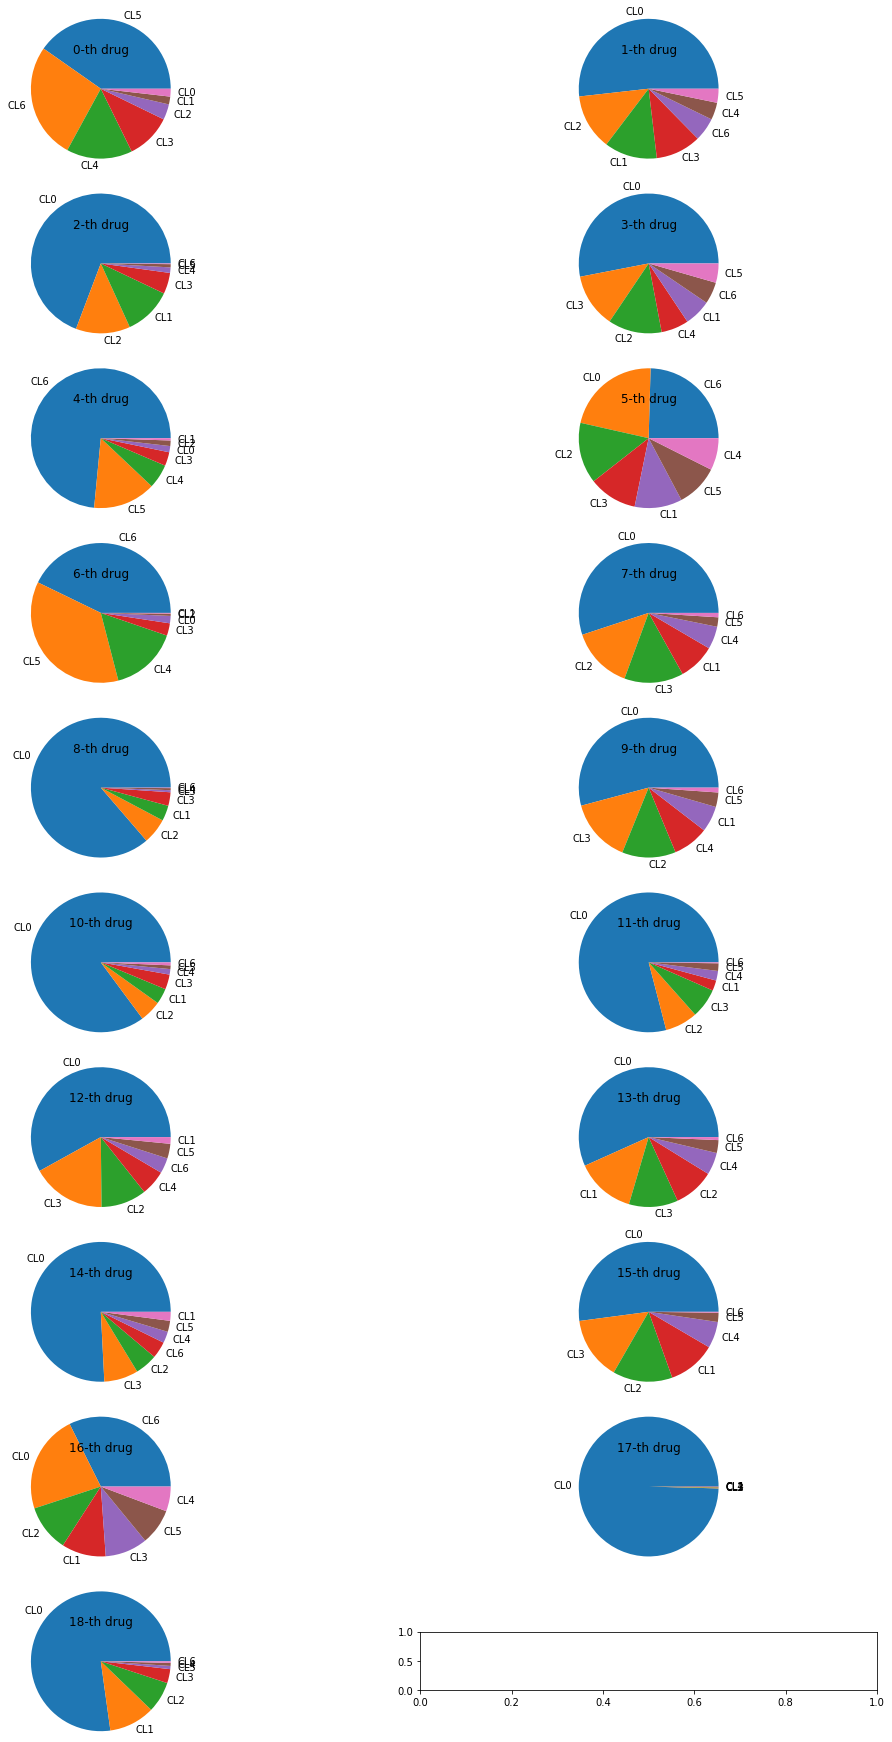

In [8]:
fig, ax = plt.subplots(10, 2, gridspec_kw={'hspace': 2},figsize=(18, 30))

for i in range(19):
    dist = Y.iloc[:, i].value_counts()
    labels = dist.index.values
    counts = dist.values
    
    ax[i // 2, i % 2].pie(counts, labels=labels, radius=3)
    ax[i // 2, i % 2].set_title(f'{i}-th drug')

Угадывать все и сразу кажется неразумным, поэтому я решил разбить задачу на классификацию по каждому таргету отдельно

Из графиков видно, что для большой части наркотиков имеет смысл решать задачу бинарной классификации:
1. (CL0, CL1, CL2) - **class 0** (Non/passive user)
2. (CL3, CL4, CL5, CL6) - **class 1** (Active user)

Можно поставить и другую, например, как предлагается на сайте CL0 + CL1

Это связано с сильным дизбалансом классов

Однако это точно не так для "наркотиков" № 0, 4, 5, 6, 16, 17 (алкоголя, кофеина, каннабиса, шоколада, никотина, семера(?))

Для них будем решать другие задачи:

1. Алкоголь: multiclass classification (CL0-CL2, CL3, CL4, CL5, CL6)
2. Кофеин: binary classification (CL0-CL5, CL6)
3. Каннабис: multiclass classification (CL0, CL1, CL2, CL3, CL4, CL5, CL6)
4. Шоколад: multiclass classification (CL0-CL4, CL5, CL6)
5. Никотин: multiclass classification (CL0, CL1-CL2, CL3-CL5, CL6)
6. Семер: вообще не будем решать никакую задачу, данных настолько мало, что единственное логичное, что можно сделать - это выдать константное предсказание

## Этап 2. Препроцессинг

Выделим отдельно таргеты для основной задачи (бинарной классификации) и таргеты для специальных случаев:

In [9]:
def main_encoder(x):
    return 0 if x in ['CL0', 'CL1', 'CL2'] else 1

def alc_encoder(x):
    if x in ['CL0', 'CL1', 'CL2']:
        return 0
    return int(x[-1]) - 2

def caf_encoder(x):
    return 0 if x != 'CL6' else 1

def can_encoder(x):
    return int(x[-1])

def choc_encoder(x):
    if x == 'CL5':
        return 1
    elif x == 'CL6':
        return 2
    return 0

def nic_encoder(x):
    if x == 'CL0':
        return 0
    elif x in ['CL1', 'CL2']:
        return 1
    elif x == 'CL6':
        return 3
    return 2

In [10]:
Y.columns = ['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc',
             'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD',
             'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']
Y.head()

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,,,,,,,,,,,,,,,,,,,
1,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [11]:
specs = np.array([i in [0, 4, 5, 6, 16, 17] for i in range(Y.columns.size)])
Y_main, Y_special = Y.iloc[:, ~specs], Y.iloc[:, specs]

In [12]:
Y_main = Y_main.applymap(main_encoder)
encoders = [alc_encoder, caf_encoder, can_encoder, choc_encoder, nic_encoder]
Y_alc = Y_special.iloc[:, 0].apply(alc_encoder)
Y_caf = Y_special.iloc[:, 1].apply(caf_encoder)
Y_can = Y_special.iloc[:, 2].apply(can_encoder)
Y_choc = Y_special.iloc[:, 3].apply(choc_encoder)
Y_nic = Y_special.iloc[:, 4].apply(nic_encoder)
Y_sem = Y_special.iloc[:, 5].apply(main_encoder)
Y_main.head()

,Amphet,Amyl,Benzos,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,VSA
0,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0


Теперь обработаем категориальные фичи: воспользуемся ordinal-encoder'ом для фичей, в которых естественнен порядок. Для остальных используем OHE

In [13]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
oe = OrdinalEncoder()

unordered_features = np.array([i in [1, 3, 4] for i in range(X.columns.size)])
ohe = OneHotEncoder(sparse=False).fit(X.iloc[:, unordered_features])

In [14]:
oe_col_names = ['Age', 'Education', 'Nscore', 'Escore', 'Oscore',
             'Ascore', 'Cscore', 'Impulsiveness', 'SS']
ohe_col_names = ['Male', 'Female', 'USA', 'New_Zealand', 'Other_country',
                 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'Asian',
                 'White', 'Mixed_WB', 'Other_ethnicity', 'Mixed_WA', 'Mixed_BA']


X_oe = pd.DataFrame(data=oe.fit_transform(X.iloc[:, ~unordered_features]), columns=oe_col_names, dtype=int)
X_ohe = pd.DataFrame(data=ohe.transform(X.iloc[:, unordered_features]), columns=ohe_col_names, dtype=int)
X = X_oe.join(X_ohe, how='inner')
X.head()

,Age,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsiveness,SS,Male,...,Ireland,Canada,UK,Black,Asian,White,Mixed_WB,Other_ethnicity,Mixed_WA,Mixed_BA
0,2,5,27,19,16,17,24,3,2,0,...,0,0,1,0,0,0,0,0,1,0
1,1,8,17,35,29,28,23,2,5,1,...,0,0,1,0,0,1,0,0,0,0
2,2,5,19,28,14,12,16,1,7,1,...,0,0,1,0,0,1,0,0,0,0
3,0,7,22,17,20,27,28,1,2,0,...,0,0,1,0,0,1,0,0,0,0
4,2,8,31,11,17,21,32,3,5,0,...,0,0,1,0,0,1,0,0,0,0


## Этап 3. Отбор признаков

После применения OHE как минимум образовались линейные зависимости, поэтому воспользуемся Lasso для отбора признаков

Из-за сильного дисбаланса классов в некоторых случаях будем использовать StratifiedKFold

In [15]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LassoCV

In [16]:
def feature_selection_lasso(X: np.ndarray, y: np.ndarray):
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    alphas = np.logspace(-4, 4, 100)
    
    clf = LassoCV(alphas=alphas, cv=cv)
    clf.fit(X, y)
    
    return clf.coef_ != 0

## Этап 4. Построение валидации

In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, make_scorer, roc_auc_score

In [18]:
def validation(X: np.ndarray, y: np.ndarray, model, ratio=0.8, n_splits=5, metric='roc_auc', rs=None):    
    if metric == 'accuracy':
        scoring_function = accuracy_score
    elif metric == 'precision':
        scoring_function = precision_score
    elif metric == 'recall':
        scoring_function = recall_score
    elif metric == 'f1':
        scoring_function = f1_score
    elif metric == 'roc_auc':
        scoring_function = roc_auc_score
    else:
        raise ValueError
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs)
    cvs = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(scoring_function), n_jobs=-1)
    return cvs

## Этап 5. Подбор гиперпараметров и выбор модели

In [19]:
from hyperopt import fmin, hp, tpe

In [20]:
def param_tuning(model, X: np.ndarray, y: np.ndarray, param_grid, scoring, evals=100): 
    def objective(params):
        clf = model(**params)
        scores = validation(X, y, clf, metric=scoring, rs=13)
        return -scores.mean()
    
    search_space = {key: hp.choice(label=key, options=value) for key, value in param_grid.items()}
    
    best_params = fmin(fn=objective,
                       space=search_space,
                       algo=tpe.suggest, 
                       max_evals=evals)
    
    return {key: value[best_params[key]] for key, value in param_grid.items()}

Можно представить, что данные прошли через MinMaxScaler, поэтому дополнительно скейлить не буду

In [21]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [22]:
svc_params = {
    'C': np.logspace(-4, 0, 100),
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr']
}

rf_params = {
    'n_estimators': np.logspace(0, 2.5, 100).astype(np.int32),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': np.arange(2, 5),
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_jobs': [-1]
}

lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 100),
    'solver': ['saga'],
    'class_weight': [None, 'balanced']
}

knn_params = {
    'n_neighbors': np.arange(3, 25, step=2),
    'weights': ['uniform', 'distance'],
    'p': np.linspace(1, 3, 5)
}

Мы задали сетку гиперпараметров для разных моделей, теперь для каждой типовой задачи найдем лучший классификатор и сделаем сводную таблицу

In [23]:
classifier_names = ['SVC', 'RF', 'LR', 'kNN']
results_main = pd.DataFrame(index=Y_main.columns, columns=classifier_names)
results_main.head()

,SVC,RF,LR,kNN
Amphet,NaN,NaN,NaN,NaN
Amyl,NaN,NaN,NaN,NaN
Benzos,NaN,NaN,NaN,NaN
Coke,NaN,NaN,NaN,NaN
Crack,NaN,NaN,NaN,NaN


In [24]:
classifiers_params = [{} for i in range(Y_main.columns.size)]
clfs = [(SVC, 'SVC', svc_params), (RandomForestClassifier, 'RF', rf_params),
        (LogisticRegression, 'LR', lr_params), (KNeighborsClassifier, 'kNN', knn_params)]

for i in range(Y_main.columns.size):
    y = Y_main.iloc[:, i].values
    X_train = X.values[:, feature_selection_lasso(X.values, y)]
    print(f'Tuning classifiers for {Y_main.columns.values[i]}')
    
    for clf_info in clfs:
        params = param_tuning(clf_info[0], X_train, y, clf_info[2], scoring='f1')
        classifiers_params[i][clf_info[1]] = params
        clf = clf_info[0](**params)
        score = validation(X_train, y, clf, metric='f1', rs=None)
        results_main.iloc[i].loc[clf_info[1]] = score.mean()

Tuning classifiers for Amphet
100%|██████████| 100/100 [00:20<00:00,  4.99trial/s, best loss: -0.3807365658127032]
Tuning classifiers for Amyl
100%|██████████| 100/100 [00:21<00:00,  4.61trial/s, best loss: -0.09319734345351043]
Tuning classifiers for Benzos
100%|██████████| 100/100 [00:08<00:00, 11.54trial/s, best loss: -0.44639886029946885]
Tuning classifiers for Coke
100%|██████████| 100/100 [00:09<00:00, 10.51trial/s, best loss: -0.36893034481712217]
Tuning classifiers for Crack
100%|██████████| 100/100 [00:08<00:00, 11.14trial/s, best loss: -0.05541125541125541]
Tuning classifiers for Ecstasy
100%|██████████| 100/100 [00:20<00:00,  4.87trial/s, best loss: -0.43580388146462445]
Tuning classifiers for Heroin
100%|██████████| 100/100 [00:14<00:00,  6.70trial/s, best loss: -0.1341726403823178]
Tuning classifiers for Ketamine
100%|██████████| 100/100 [00:08<00:00, 11.32trial/s, best loss: -0.12688881567376292]
Tuning classifiers for Legalh
100%|██████████| 100/100 [00:19<00:00,  5.11tr

Я смотрел несколько метрик, ROC AUC примерно одинаковый у всех классификаторов (в случае его максимизации hyperopt-ом), а вот F-мера сильно отличается. Выбор метрики, конечно, зависит от задачи, но так как она поставлена условно, я решил остановится на наиболее общей и отличающейся метрике. Теперь можно сказать, что наша задача - как можно точнее и полнее определять активных пользователей наркотических средств

In [25]:
results_main

,SVC,RF,LR,kNN
Amphet,0.4543,0.5719,0.5813,0.3928
Amyl,0.0000,0.1889,0.2438,0.0493
Benzos,0.5395,0.5311,0.5768,0.4127
Coke,0.0000,0.4414,0.5189,0.3611
Crack,0.0000,0.1447,0.1246,0.0956
Ecstasy,0.5466,0.5975,0.6181,0.4342
Heroin,0.0000,0.2145,0.1924,0.0948
Ketamine,0.0148,0.2590,0.3450,0.1210
Legalh,0.6522,0.6554,0.6712,0.5645
LSD,0.5781,0.6431,0.6309,0.3479


Лучший результат показала логистическая регрессия, чуть хуже отработал случайный лес

Можно попробовать улучшить качество смесью моделей LogReg и RandomForest и проверить ее на кросс валидации

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [27]:
class MixedEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator1, estimator2, alpha):
        self.estimator1 = estimator1
        self.estimator2 = estimator2
        self.alpha = alpha
        
    def fit(self, X, y=None):
        self.estimator1.fit(X, y)
        self.estimator2.fit(X, y)
        
    def predict_proba(self, X):
        return self.alpha * self.estimator1.predict_proba(X) + (
            1 - self.alpha) * self.estimator2.predict_proba(X)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [28]:
alphas = []
mixed_scores = []

for i in range(Y_main.columns.size):
    y = Y_main.iloc[:, i].values
    X_train = X.values[:, feature_selection_lasso(X.values, y)]
    
    print(f'Tuning alpha for {Y_main.columns.values[i]}')
    
    rf_params = classifiers_params[i]['RF']
    lr_params = classifiers_params[i]['LR']
    estimator1, estimator2 = RandomForestClassifier(**rf_params), LogisticRegression(**lr_params)
    
    def alpha_objective(params):
        alpha = params['alpha']

        clf = MixedEstimator(estimator1, estimator2, alpha)
        scores = validation(X_train, y, clf, metric='f1', rs=None)
        return -scores.mean()
    
    alpha_space = {
        'alpha': hp.uniform('alpha', 0, 1)
    }
    
    best_alpha = fmin(fn=alpha_objective,
                      space=alpha_space,
                      algo=tpe.suggest,
                      max_evals=100)
    
    alphas.append(best_alpha['alpha'])
    clf = MixedEstimator(estimator1, estimator2, best_alpha['alpha'])
    mixed_scores.append(validation(X_train, y, clf, metric='f1', rs=None).mean())

Tuning alpha for Amphet
100%|██████████| 100/100 [00:40<00:00,  2.49trial/s, best loss: -0.601082296561197]
Tuning alpha for Amyl
100%|██████████| 100/100 [00:12<00:00,  8.12trial/s, best loss: -0.2682853293299824]
Tuning alpha for Benzos
100%|██████████| 100/100 [01:17<00:00,  1.29trial/s, best loss: -0.5922537454096389]
Tuning alpha for Coke
100%|██████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: -0.5326214647255991]
Tuning alpha for Crack
100%|██████████| 100/100 [00:11<00:00,  8.89trial/s, best loss: -0.22598500939964355]
Tuning alpha for Ecstasy
100%|██████████| 100/100 [00:23<00:00,  4.33trial/s, best loss: -0.6435119169529291]
Tuning alpha for Heroin
100%|██████████| 100/100 [00:12<00:00,  7.90trial/s, best loss: -0.3185343569034834]
Tuning alpha for Ketamine
100%|██████████| 100/100 [00:09<00:00, 10.79trial/s, best loss: -0.3632298301529623]
Tuning alpha for Legalh
100%|██████████| 100/100 [00:38<00:00,  2.60trial/s, best loss: -0.6799389554592621]
Tuning alpha for LSD


In [29]:
results_main['Mixed'] = mixed_scores

In [30]:
results_main

,SVC,RF,LR,kNN,Mixed
Amphet,0.4543,0.5719,0.5813,0.3928,0.5859
Amyl,0.0000,0.1889,0.2438,0.0493,0.2490
Benzos,0.5395,0.5311,0.5768,0.4127,0.5785
Coke,0.0000,0.4414,0.5189,0.3611,0.5198
Crack,0.0000,0.1447,0.1246,0.0956,0.0960
Ecstasy,0.5466,0.5975,0.6181,0.4342,0.6185
Heroin,0.0000,0.2145,0.1924,0.0948,0.2991
Ketamine,0.0148,0.2590,0.3450,0.1210,0.3445
Legalh,0.6522,0.6554,0.6712,0.5645,0.6705
LSD,0.5781,0.6431,0.6309,0.3479,0.6345


В целом, я бы сказал, что результаты Mixed модели находятся в пределах погрешности от результатов логистической регрессии

## Этап 6. Multiclass и другие специальные случаи

На самом деле интересно посмотреть на accuracy для никотина и каннабиса, так как там довольно сбалансированные классы. Все остальное можно обработать либо предыдущими способами, либо использованными ниже

In [31]:
yn = Y_nic.values
yc = Y_can.values

mc_lr_params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 0, 100),
    'solver': ['saga'],
    'class_weight': [None, 'balanced'],
    'multi_class': ['ovr', 'multinomial']
}

mc_rf_params = {
    'n_estimators': np.logspace(0, 2.5, 100).astype(np.int32),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': np.arange(2, 5),
    'min_samples_leaf': [1, 2, 3],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_jobs': [-1]
}

In [32]:
scores = []

for y in [yn, yc]:
    X_train = X.values[:, feature_selection_lasso(X, y)]
    best_params = param_tuning(LogisticRegression, X_train, y, mc_lr_params, scoring='accuracy')

    clf = LogisticRegression(**best_params)
    scores.append(validation(X_train, y, clf, metric='accuracy').mean())

print(f'Logistic regression CV scores:\nNicotine: {scores[0]}\nCannabis: {scores[1]}')

100%|██████████| 100/100 [00:33<00:00,  3.01trial/s, best loss: -0.41432360742705576]
Logistic regression CV scores:
Nicotine: 0.4222811671087533
Cannabis: 0.4090185676392573


In [33]:
scores = []

for y in [yn, yc]:
    X_train = X.values[:, feature_selection_lasso(X, y)]
    best_params = param_tuning(RandomForestClassifier, X_train, y, mc_rf_params, scoring='accuracy')

    clf = RandomForestClassifier(**best_params)
    scores.append(validation(X_train, y, clf, metric='accuracy').mean())

print(f'Random forest CV scores:\nNicotine: {scores[0]}\nCannabis: {scores[1]}')

100%|██████████| 100/100 [00:37<00:00,  2.67trial/s, best loss: -0.41432360742705576]
Random forest CV scores:
Nicotine: 0.4228116710875332
Cannabis: 0.4095490716180371


На мой взгляд это довольно впечатляющая точность, для классификации на 7 классов

### **Задание №4**. 
Предположим, что мы построили рекомендательную систему, и ожидаем, что средний чек клиента вследствие этого должен вырасти. Мы провели AB-тест и собрали данные по контрольной и тестовой группе. Предложите и проведите статистический тест, который можно применить к этим данным.

В процессе выполнения задания разрешено пользоваться библиотеками scipy и statsmodels.

In [34]:
# Сгенерируем данные для задачи
control = np.random.lognormal(mean=5, sigma=2, size=(100000,))
test = np.random.lognormal(mean=5.04, sigma=2, size=(100000,))

Обозначим $\mathbf{X}$ - контрольная выборка; $\mathbf{Y}$ - тестовая выборка


Сконструируем тест Вальда для **равенства средних**: 
$$ \mu_1 = \overline{\mathbf{X}}, \; \mu_2 = \overline{\mathbf{Y}}, \; 
\hat{\sigma} = \sqrt{\hat{\sigma}^2_{\mathbf{X}} + 
\hat{\sigma}^2_{\mathbf{Y}}}$$
$$$$
$$ \hat{\sigma}_{\mathbf{Y}}, \; \hat{\sigma}_{\mathbf{X}} - \text{оценки стандартных ошибок оценок средних} $$
$$$$
$$ \mathbf{W} = \frac{\mu_1 - \mu_2}{\hat{\sigma}} \sim \mathcal{N}(0, 1) $$
Итоговая формула:
$$
\mathbf{W} = \frac{\mu_1 - \mu_2}
{\sqrt{\frac{s_{\mathbf{X}}}{n_{\mathbf{X}}} + 
\frac{s_{\mathbf{Y}}}{n_{\mathbf{Y}}}}} 
$$
Где $ s_{\mathbf{X}}, \, s_{\mathbf{Y}}$ - выборочные дисперсии, а 
$n_{\mathbf{X}}, \, n_{\mathbf{Y}}$ - размеры выборок

In [35]:
from scipy.stats import norm

In [36]:
def mean_equality_test(X: np.array, Y: np.array, conf_level=0.05) -> bool:
    mu_x, mu_y = X.mean(), Y.mean()
    nx, ny = X.size, Y.size
    vx, vy = X.var(ddof=1), Y.var(ddof=1)
    
    quant = norm.ppf(1 - conf_level / 2)
    w = abs((mu_x - mu_y) / np.sqrt(vx / nx + vy / ny))
    print(w, quant)
    return w < quant

In [37]:
print(f'Тест равенства средних: {mean_equality_test(control, test)}')

1.1571985692964997 1.959963984540054
Тест равенства средних: True


### **Задание №4 (*)**. 
В прошлом задании мы улавливали статистически значимое различие в средних в 0.04 единицы на выборке из 100000 клиентов. Насколько больше нам требуется собрать клиентов, чтобы уловить различие в 0.02?

Считаем, что разница в 0.04 статистически значима, тогда заменяя оценки дисперсии оценок средних настоящими значениями дисперсии, и так как $n_{\mathbf{X}} = n_{\mathbf{Y}}$:
$$ \newcommand{\Var}[1]{\mathbb{V}{\left[#1\right]}} $$
$$
\mathbf{W} = \frac{\mu_1 - \mu_2}
{\sqrt{\frac{\Var{\mathbf{X}}}{n} + 
\frac{\Var{\mathbf{Y}}}{n}}} = 
\sqrt{n}\cdot\frac{\mu_1 - \mu_2}{\sqrt{\Var{\mathbf{X}} + \Var{\mathbf{Y}}}}
$$
Поскольку дальше статистика $\mathbf{W}$ просто сравнивается с $\left(1 - \alpha/2\right)$-квантилью нормального распределения, то для одинакового уровня значимости надо приравнять статистики $\mathbf{W}$

Подставляя значения:
$$
\sqrt{100000} \cdot \frac{0.04}{\sqrt{\Var{\mathbf{X}} + \Var{\mathbf{Y}}}} =
\sqrt{m} \cdot \frac{0.02}{\sqrt{\Var{\mathbf{X}} + \Var{\mathbf{Y}}}} 
$$
$$
m = 400000
$$
Потребуется в 4 раза больше клиентов (на 300000)